In [86]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# VEST AL 2020
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Alabama Secretary of State Elections Division (https://www.sos.alabama.gov/alabama-votes/voter/election-data). 

#### Processing
Absentee and provisional ballots were reported countywide in all counties. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.


### Shapefiles

#### Sources
Precinct shapefiles initially from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

### Processing
Precinct boundaries were adjusted as appropriate to align with county maps, municipal boundaries, or commission districts. Precinct boundaries throughout the state were further reviewed with the voter registration file in effect for the November 2020 general election. Voting districts in nearly all counties were edited accordingly to align with reporting units in the 2020 election results. In many counties the resulting boundaries bear little resemblance to the 2020 Census VTDs. As these boundary revisions were so extensive only splits and merges are specified below by precinct.

Many precincts have outdated names in the Census VTDs. The Census VTDs also have at least some precinct names in wrong locations for the following counties: Clarke, Clay, Cleburne, Conecuh, Dallas, Escambia, Geneva, Greene, Jefferson, Lauderdale, Limestone, Marion, Marshall, Monroe, Perry, Randolph, Russell, Tallapoosa, Walker, Washington, Wilcox. Moreover, many precinct numbers and consequently the VTD GeoIDs are also incorrect throughout much of the state in the Census shapefiles. All precinct names and numbers have been edited to match the 2020 voter file.

The following splits and merges were made to align voting district boundaries with reporting units in the 2020 election results.

- Barbour: Split Eufaula between Bevill/CC/Fellowship/McCoo/Sanford/WB
- Calhoun: Add precinct splits to Beats 1, 4, 5, 9, 12, 13, 15, 19, 22
- Cherokee: Split Friendship/Mt Calvary, McCord's/Rock Run, Mt Weisner/VFD #2
- Choctaw: Split Cromwell/Halsell/Intersection
- Clarke: Split Antioch/Grove Hill/Helwestern, Choctaw Bluff/Gainstown, Grove Hill NG/Whatley, Jackson/Skipper, Springfield/Thomasville; Merge Fulton FS/CH
- Colbert: Merge Mynot into Allsboro/Cherokee
- Covington: Split Heath/Straughn, Pleasant Home/Wing
- Cullman: Split Cullman City Hall/Civic Ctr/Conf Room/Courthouse
- Dallas: Merge Marion Jct/New Friendship
- DeKalb: Merge Antioch/Fyffe, Pea Ridge into Hammondville/Henagar/Ider, Five Points/Senior Center
- Etowah: Merge Fords Valley/Hokes Bluff, Tabernacle/Walnut Park
- Fayette: Split Browns-Glen Allen/Whites Chapel, Cole-Killingsworth/Paul Hubbert, Fayette CC/Covin/YC, Lee-Belk/Palestine
- Geneva: Split Bellwood/El Bethel, Flat Creek/Hacoda, Hughes VH/Malvern, Lowery/Revels, Piney Grove/Samson, Slocomb/Tate
- Jackson: Merge Aspel/Limrock, Bishop Hall/Estill Fork, Christian Home/Flat Rock, Garth/Trenton, Hambrick/Hollytree/Princeton
- Jefferson: Split 3030/3035 Bethel Baptist/Pleasant Grove; Merge 1120/1260 as Robinson Elementary, 2350/5270 as Oxmoor Valley
- Marion: Split Kimbrough N/S; Merge Hamilton N/S as ET Sims
- Monroe: Split Chrysler/Mineola, Coleman/Excel, Franklin/Wainwright, Peterman/Philadelphia
- Randolph: Split Bethel/Moores/Woodland, Cavers/Swagg, Corinth/Morrison, Midway/New Hope/Wedowee, Omaha/Tin Shop/Wehadkee, Rock Mills/Wilson
- Russell: Split Courthouse/Golden Acres
- Tallapoosa: Split Cooper/Duncan/Moncrief; Merge New Paces 901/902 to match county shapefile
- Wilcox: Split National Guard Camden, Pine Apple Comm Ctr, Pine Apple AWIN, St Paul Church
- Winston: Split Addison/Upshaw, Delmar/Natural Bridge, Haleyville/Neighborhood/Pebble/Waldrop, Lynn/Old Union, Nesmith/Helicon


# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [87]:
vest_al_20 = gp.read_file("./raw-from-source/VEST/al_2020/al_2020.shp")

In [88]:
vest_al_20.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

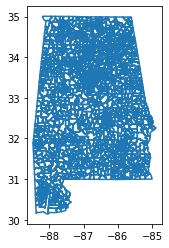

In [89]:
vest_al_20.boundary.plot()

In [90]:
vest_al_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'NAME20', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREOWRI', 'G20USSRTUB', 'G20USSDJON',
       'G20USSOWRI', 'G20SSCRSHA', 'G20SSCOWRI', 'G20SSCRMEN', 'G20SSCOWR2',
       'G20SACRTHO', 'G20SACOWRI', 'G20SACRFRI', 'G20SACOWR2', 'G20SCCRWIN',
       'G20SCCOWRI', 'G20SCCRKEL', 'G20SCCOWR2', 'G20PSCRCAV', 'G20PSCDCAS',
       'G20PSCOWRI', 'geometry'],
      dtype='object')

In [91]:
vest_al_20.head(5)

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREOWRI,G20USSRTUB,...,G20SACRFRI,G20SACOWR2,G20SCCRWIN,G20SCCOWRI,G20SCCRKEL,G20SCCOWR2,G20PSCRCAV,G20PSCDCAS,G20PSCOWRI,geometry
0,01,013,000100,01013000100,Monterey School House,25,37,2,0,25,...,26,1,26,1,25,1,25,35,0,"POLYGON ((-86.90894 31.96167, -86.90632 31.961..."
1,01,013,000181,01013000181,Bolling,100,50,0,0,95,...,101,1,101,1,99,1,99,48,0,"POLYGON ((-86.71867 31.73289, -86.71864 31.732..."
2,01,053,000080,01053000080,Rock Hill-Ridge VFD,265,60,3,0,251,...,262,5,259,6,262,4,257,63,0,"POLYGON ((-87.05166 31.11854, -87.04869 31.118..."
3,01,053,000120,01053000120,Damascus-Boykin School,180,143,2,1,172,...,189,2,189,2,189,2,171,145,0,"POLYGON ((-86.95858 31.16635, -86.95844 31.166..."
4,01,053,000100,01053000100,Bradley VFD,68,2,0,0,67,...,70,0,70,0,70,0,69,2,0,"POLYGON ((-86.82985 31.02083, -86.82983 31.020..."


### Create a FIPs dictionary

In [92]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Alabama"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
al_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Election Results

### Load, Pivot, Clean Election Results

There is a directory of excel files that need to be pivoted of election results. 

First, confirm that the file structure is the same for all of the files:

In [93]:
files = os.listdir('./raw-from-source/SOS/2020GeneralPrecinctResults/')

In [94]:
temp = pd.read_excel('./raw-from-source/SOS/2020GeneralPrecinctResults/2020-General-Autauga.xls')
columns = temp.columns
print(columns)

flag = True
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2020GeneralPrecinctResults/' + file)
    if columns.to_list()[:3] != temp.columns.to_list()[:3]:
        print(columns)
        print(temp.columns)
        flag = False
if flag:
    print('All files have the same first 3 columns: ', columns.to_list()[:3])

Index(['Contest Title', 'Party', 'Candidate', '10 JONES COMM_ CTR_',
       '100 TRINITY METHODIST', '110 CENTRAL AL ELECTRIC',
       '140 AUTAUGAVILLE VFD', '150 PRATTMONT BAPTIST',
       '160 DOSTER COMM_ CTR_', '170 CAMELLIA BAPTIST CHURCH',
       '180 OLD KINGSTON VFD', '20 HERITAGE BAPTIST', '220 UPPER KINGSTON',
       '230 COUNTY LINE BAPTIST', '30 BILLINGSLEY COMM_ CTR_',
       '40 E_ MEMORIAL CHRISTIAN', '50 WHITE CITY VFD', '60 MARBURY MIDDLE',
       '70 BOONE'S CHAPEL', '80 INDEPENDENCE VFD', '90 BOOTH VFD', 'ABSENTEE',
       'PROVISIONAL'],
      dtype='object')
All files have the same first 3 columns:  ['Contest Title', 'Party', 'Candidate']


Next, go through and pivot each file, clean them, and concatenate. 

In [95]:
def pivot_clean_county_file(df, county_name): 
    """Given a dataframe, pivot the table, order and rename columns, and return the cleaned table that can be concatenated. """
    
    df_pivot = pd.pivot_table(df,values=[x for x in df.columns.to_list() if x not in ('Contest Title','Party','Candidate')],
                              columns=['Contest Title',"Candidate"],aggfunc=sum)
    df_pivot['county'] = county_name
    df_pivot.reset_index(inplace = True)
    df_pivot.columns = [(x.strip(), y.strip()) for x,y in df_pivot.columns.values]
    
    if county_name in ('Randolph'):
        president = [('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Donald J. Trump Michael R. Penc'), 
            ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Joseph R. Biden Kamala D. Harri'), 
            ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Jo Jorgensen Jeremy "Spike" Coh'), 
            ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Write-In')]
    elif county_name in ('Barbour'):
        president = [('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Donald J. Trump'),
                          ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Joseph R. Biden'),
                          ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Jo Jorgensen Jeremy "Spike" Cohen'), 
                          ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Write-In')]
    else:
        president = [('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Donald J. Trump'),
                          ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Joseph R. Biden'),
                          ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Jo Jorgensen'),
                          ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Write-In')]
    
    clean_df = df_pivot[[('index',''),('county','')] + president + 
                          [('UNITED STATES SENATOR', 'Tommy Tuberville'),
                          ('UNITED STATES SENATOR', 'Doug Jones'),
                          ('UNITED STATES SENATOR', 'Write-In'),
                          ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Greg Shaw'),
                          ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Write-In'),
                          ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Brad Mendheim'),
                          ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Write-In'),
                          ('COURT OF CIVIL APPEALS JUDGE, PLACE 1', 'William C. "Bill" Thompson'),
                          ('COURT OF CIVIL APPEALS JUDGE, PLACE 1', 'Write-In'),
                          ('COURT OF CIVIL APPEALS JUDGE, PLACE 2', 'Matt Fridy'),
                          ('COURT OF CIVIL APPEALS JUDGE, PLACE 2', 'Write-In'),
                          ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 1', 'Mary Windom'),
                          ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 1', 'Write-In'),
                          ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 2', 'Beth Kellum'),
                          ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 2', 'Write-In'),
                          ('PRESIDENT, PUBLIC SERVICE COMMISSION', 'Twinkle Andress Cavanaugh'),
                          ('PRESIDENT, PUBLIC SERVICE COMMISSION', 'Laura Casey'),
                          ('PRESIDENT, PUBLIC SERVICE COMMISSION', 'Write-In')]]
    clean_df.columns = ['precinct','county',
                        'G20PRERTRU','G20PREDBID','G20PRELJOR','G20PREOWRI',
                        'G20USSRTUB','G20USSDJON','G20USSOWRI',
                        'G20SSCRSHA','G20SSCOWRI',
                        'G20SSCRMEN','G20SSCOWR2',
                        'G20SACRTHO','G20SACOWRI',
                        'G20SACRFRI','G20SACOWR2',
                        'G20SCCRWIN','G20SCCOWRI',
                        'G20SCCRKEL','G20SCCOWR2',
                        'G20PSCRCAV','G20PSCDCAS','G20PSCOWRI']
    
    return clean_df


In [96]:
flag = 0
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2020GeneralPrecinctResults/' + file)
#     print(file.split('-')[2][:-4])
    clean_df = pivot_clean_county_file(temp, file.split('-')[2][:-4])
    if flag == 0:
        results_2020 = clean_df
        flag = 1
    else:
        results_2020 = pd.concat([results_2020, clean_df])

Add county fips to election results file

In [97]:
# Change column names to match the county fips dict
results_2020.loc[results_2020['county'] == 'StClair', 'county'] = 'St Clair'
results_2020.loc[results_2020['county'] == 'DeKalb', 'county'] = 'De Kalb'

#Map to the correct FIP
results_2020["county_fips"]=results_2020["county"].map(al_fips_dict).fillna(results_2020["county"])

#Print out the FIPS to make sure they all are in the correct format
results_2020["county_fips"].unique()

array(['015', '007', '039', '077', '091', '017', '111', '103', '061',
       '083', '029', '041', '019', '047', '025', '071', '107', '069',
       '001', '129', '105', '097', '045', '051', '055', '043', '117',
       '037', '065', '087', '053', '085', '123', '125', '059', '099',
       '115', '049', '127', '057', '063', '093', '075', '005', '003',
       '113', '095', '121', '133', '073', '067', '031', '011', '109',
       '033', '119', '021', '035', '101', '023', '131', '027', '079',
       '009', '081', '089', '013'], dtype=object)

In [98]:
results_2020.shape

(2111, 25)

In [99]:
vest_al_20.shape

(1972, 28)

## Compare Election Results Totals

### Compare Total Votes

In [100]:
races = [x for x in vest_al_20.columns if 'G20' in x]
races

['G20PRERTRU',
 'G20PREDBID',
 'G20PRELJOR',
 'G20PREOWRI',
 'G20USSRTUB',
 'G20USSDJON',
 'G20USSOWRI',
 'G20SSCRSHA',
 'G20SSCOWRI',
 'G20SSCRMEN',
 'G20SSCOWR2',
 'G20SACRTHO',
 'G20SACOWRI',
 'G20SACRFRI',
 'G20SACOWR2',
 'G20SCCRWIN',
 'G20SCCOWRI',
 'G20SCCRKEL',
 'G20SCCOWR2',
 'G20PSCRCAV',
 'G20PSCDCAS',
 'G20PSCOWRI']

In [101]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_al_20[i])
    sum_var_2 += np.sum(results_2020[i])
print(sum_var_1)
print(sum_var_2)

16388212
16388212.0


### Compare County Totals

The `compare()` method shows rows where the values are different, by default. So displaying nothing here is good, all county race totals are equal. 

In [102]:
vest_al_20.groupby('COUNTYFP20')['G20PRERTRU'].sum().compare(results_2020.groupby('county_fips')['G20PRERTRU'].sum())

,self,other


In [103]:
vest_al_20.groupby('COUNTYFP20')['G20PRERTRU'].sum().compare(results_2020.groupby('county_fips')['G20PRERTRU'].sum(), keep_shape = True, keep_equal = True)

,self,other
001,19838,19838.0
003,83544,83544.0
005,5622,5622.0
007,7525,7525.0
009,24711,24711.0
...,...,...
125,51117,51117.0
127,26002,26002.0
129,6564,6564.0
131,1833,1833.0


### Compare Race Totals

In [104]:
for race in races:
    diff_val = sum(vest_al_20[race])-sum(results_2020[race])
    if diff_val != 0:
        print(race+": "+str(diff_val), "\tVEST sum: ", sum(vest_al_20[race]), "\tRDH sum: ", sum(results_2020[race]))
    else:
        print(race+": EQUAL")

G20PRERTRU: EQUAL
G20PREDBID: EQUAL
G20PRELJOR: EQUAL
G20PREOWRI: EQUAL
G20USSRTUB: EQUAL
G20USSDJON: EQUAL
G20USSOWRI: EQUAL
G20SSCRSHA: EQUAL
G20SSCOWRI: EQUAL
G20SSCRMEN: EQUAL
G20SSCOWR2: EQUAL
G20SACRTHO: EQUAL
G20SACOWRI: EQUAL
G20SACRFRI: EQUAL
G20SACOWR2: EQUAL
G20SCCRWIN: EQUAL
G20SCCOWRI: EQUAL
G20SCCRKEL: EQUAL
G20SCCOWR2: EQUAL
G20PSCRCAV: EQUAL
G20PSCDCAS: EQUAL
G20PSCOWRI: EQUAL


### Compare Precinct-by-Precinct Totals

In [105]:
print(results_2020)

results_2020["unique_ID"] = results_2020["county_fips"] +"-"+results_2020["precinct"]

                    precinct   county  G20PRERTRU  G20PREDBID  G20PRELJOR  \
0   1ST UN_ METHODIST-WEAVER  Calhoun      1776.0       457.0        48.0   
1                   ABSENTEE  Calhoun      1925.0      2715.0        31.0   
2    ALEXANDRIA CIVITAN CLUB  Calhoun      2029.0       271.0        21.0   
3         ANGEL FIRE STATION  Calhoun       636.0       112.0        11.0   
4        ANNISTON 1ST PRSBY_  Calhoun       168.0       110.0         7.0   
..                       ...      ...         ...         ...         ...   
19               PROVISIONAL   Butler        10.0        12.0         0.0   
20     ROCKY CREEK VTG HOUSE   Butler       248.0        39.0         1.0   
21                SEARCY VFD   Butler       162.0        51.0         4.0   
22    SR_ MULTI-PURPOSE CTR_   Butler       320.0       504.0         0.0   
23           STEINER'S STORE   Butler       147.0        22.0         3.0   

    G20PREOWRI  G20USSRTUB  G20USSDJON  G20USSOWRI  G20SSCRSHA  ...  \
0   

In [106]:
pro_ab_list = list(results_2020[(results_2020["precinct"].str.contains("ABSENTEE")) |(results_2020["precinct"].str.contains("PROVISIONAL"))]["unique_ID"])

In [130]:
results_2020[(results_2020["precinct"].str.contains("ABSENTEE")) |(results_2020["precinct"].str.contains("PROVISIONAL"))]["unique_ID"].str[0:3].value_counts()

089    3
073    3
117    2
065    2
077    2
      ..
021    2
037    2
045    2
035    2
123    2
Name: unique_ID, Length: 67, dtype: int64

In [ ]:
#'073-BESSEMER ABSENTEE', '073-BIRMINGHAM ABSENTEE'
# '089-ABSENTEE 1', '089-ABSENTEE 2'

In [150]:
print(results_2020["county"].unique())

['Calhoun' 'Bibb' 'Covington' 'Lauderdale' 'Marengo' 'Chambers' 'Randolph'
 'Morgan' 'Geneva' 'Limestone' 'Cleburne' 'Crenshaw' 'Cherokee' 'Dallas'
 'Clarke' 'Jackson' 'Pickens' 'Houston' 'Autauga' 'Washington' 'Perry'
 'Mobile' 'Dale' 'Elmore' 'Etowah' 'Cullman' 'Shelby' 'Coosa' 'Hale'
 'Macon' 'Escambia' 'Lowndes' 'Tallapoosa' 'Tuscaloosa' 'Franklin'
 'Monroe' 'St Clair' 'De Kalb' 'Walker' 'Fayette' 'Greene' 'Marion'
 'Lamar' 'Barbour' 'Baldwin' 'Russell' 'Marshall' 'Talladega' 'Winston'
 'Jefferson' 'Henry' 'Coffee' 'Bullock' 'Pike' 'Colbert' 'Sumter'
 'Chilton' 'Conecuh' 'Montgomery' 'Choctaw' 'Wilcox' 'Clay' 'Lawrence'
 'Blount' 'Lee' 'Madison' 'Butler']


In [136]:
birmingham_precs = pd.read_csv("./birmingham_precs.csv")
bessemer_precs = pd.read_csv("./bessemer_precs.csv")

In [146]:
for val in results_jeff_list:
    if val in list(birmingham_precs["name"]):
        print(val + "in birm")
    elif val in list(bessemer_precs["name"]):
        print(val + "in bess")
    else:
        print(val + "in none :(")

PREC 1010 - OUR LADY OF LOURDEin none :(
PREC 1020 - TOM BRADFORD PARKin birm
PREC 1030 - L_M_ SMITH MIDDLEin none :(
PREC 1040 - BETHEL BAPTIST CHUin none :(
PREC 1050 - MIDFIELD COMMUNITYin none :(
PREC 1060 - SUN VALLEY ELEMENTin none :(
PREC 1070 - CRESTWAY BAPTIST Cin none :(
PREC 1080 - GEORGE FRENCH STUDin none :(
PREC 1090 - FORESTDALE SQUAREin birm
PREC 1100 - SOUTH HAMPTON ELEMin none :(
PREC 1110 - DON HAWKINS PARK &in none :(
PREC 1120 - ROBINSON ELEMENTARin none :(
PREC 1130 - MARTHA GASKINS ELEin none :(
PREC 1140 - WOODLAWN PUBLIC LIin none :(
PREC 1150 - ADAMSVILLE CHURCHin none :(
PREC 1160 - FAITH CHAPEL CHRISin none :(
PREC 1170 - HUDSON MIDDLE SCHOin none :(
PREC 1180 - BARRETT ELEMENTARYin none :(
PREC 1190 - INGLENOOK ELEMENTAin none :(
PREC 1200 - NORWOOD COMMUNITYin none :(
PREC 1210 - GLEN OAKS ELEMENTAin none :(
PREC 1220 - WILLOW WOOD RECREAin none :(
PREC 1230 - NEW RISING STAR MIin none :(
PREC 1240 - MT_ PILGRIM BAPTISin none :(
PREC 1250 - FORESTDALE FIRE

In [144]:
print(birmingham_precs["name"])
print(bessemer_precs["name"])

0      PREC 1010 - OUR LADY OF LOURDES CATHOLIC CHURCH
1                        PREC 1020 - TOM BRADFORD PARK
2                 PREC 1030 - L.M. SMITH MIDDLE SCHOOL
3                    PREC 1040 - BETHEL BAPTIST CHURCH
4             PREC 1060 - SUN VALLEY ELEMENTARY SCHOOL
                            ...                       
127        PREC 5240 - SHADES CAHABA ELEMENTARY SCHOOL
128                PREC 5250 - CHURCH OF THE HIGHLANDS
129     PREC 5260 - CANTERBURY UNITED METHODIST CHURCH
130           PREC 5280 - BIRMINGHAM BOTANICAL GARDENS
131             PREC 5290 - AFTON LEE COMMUNITY CENTER
Name: name, Length: 132, dtype: object
0                 PREC 1050 - MIDFIELD COMMUNITY CENTER
1                         PREC 1080 - MILES COLLEGE GYM
2               PREC 1210 - GLEN OAKS ELEMENTARY SCHOOL
3                PREC 1240 - MT. PILGRIM BAPTIST CHURCH
4                    PREC 1350 - FAIRFIELD CIVIC CENTER
5                PREC 1380 - ST. MARY'S CATHOLIC CHURCH
6         PREC 2060 

In [107]:
global non_prov_absentee
non_prov_absentee = results_2020[~results_2020["unique_ID"].isin(pro_ab_list)]
prov_absentee = results_2020[results_2020["unique_ID"].isin(pro_ab_list)]

In [148]:
results_jeff_list = non_prov_absentee[non_prov_absentee["county_fips"]=="073"]["precinct"] 
results_jeff_list.to_csv("./jeff_elections.csv")

In [ ]:
jeff_assignments = pd.read_csv("")

In [109]:
print(vest_al_20)

vest_al_20["unique_ID"] = vest_al_20["COUNTYFP20"] +"-"+vest_al_20["NAME20"].str.upper()

     STATEFP20 COUNTYFP20 VTDST20      GEOID20                  NAME20  \
0           01        013  000100  01013000100   Monterey School House   
1           01        013  000181  01013000181                 Bolling   
2           01        053  000080  01053000080     Rock Hill-Ridge VFD   
3           01        053  000120  01053000120  Damascus-Boykin School   
4           01        053  000100  01053000100             Bradley VFD   
...        ...        ...     ...          ...                     ...   
1967        01        017  000006  01017000006                Fredonia   
1968        01        017  000001  01017000001           Standing Rock   
1969        01        017  000012  01017000012                 Cusseta   
1970        01        017  000010  01017000010           West Chambers   
1971        01        043  000016  01043000016    Courthouse Conf Room   

      G20PRERTRU  G20PREDBID  G20PRELJOR  G20PREOWRI  G20USSRTUB  ...  \
0             25          37          

In [110]:
def vote_merger (merge_list,new_name):
    global non_prov_absentee
    races = [x for x in vest_al_20.columns if 'G20' in x]
    #Add in the other votes
    
    for i in range(1,len(merge_list)):
        for race in races:
            non_prov_absentee.loc[non_prov_absentee["unique_ID"]==merge_list[0],race]+=int(non_prov_absentee.loc[non_prov_absentee["unique_ID"]==merge_list[i],race])
    
    #Update the unique ID
    non_prov_absentee.loc[non_prov_absentee["unique_ID"]==merge_list[0],"unique_ID"]=new_name
    
    #Remove the ones that aren't needed
    non_prov_absentee = non_prov_absentee[~non_prov_absentee["unique_ID"].isin(merge_list[1:])]
    
    non_prov_absentee.reset_index(inplace=True,drop=True)

In [111]:
vote_merger(["043-FAIRVIEW FIRE DEPT_ A-K","043-FAIRVIEW TOWN HALL_ L-Z"],"043-FAIRVIEW FD/TOWN HALL")
vote_merger(["111-NATIONAL GUARD ARMORY 1","111-NATIONAL GUARD ARMORY 2","111-NATIONAL GUARD ARMORY 3"],"111-National Guard Armory")
vote_merger(["111-WEDOWEE CITY HALL 1","111-WEDOWEE CITY HALL 2"],"111-Wedowee City Hall")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [112]:
attempt_one = pd.merge(non_prov_absentee,vest_al_20,indicator=True,how="outer",on="unique_ID")
print(attempt_one["_merge"].value_counts())

elections_only = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only.to_csv("./only_elections.csv")

vest_only = attempt_one[attempt_one["_merge"]=="right_only"]
vest_only.to_csv("./only_vest.csv")

right_only    1396
left_only     1395
both           576
Name: _merge, dtype: int64


In [134]:
len(list(non_prov_absentee[non_prov_absentee["county_fips"]=="073"]["precinct"]))

172

In [114]:
precinct_specific_totals = non_prov_absentee.groupby("county_fips").sum()
to_dole_out_totals = prov_absentee.groupby("county_fips").sum()

precinct_specific_totals.reset_index(drop=False,inplace=True)
to_dole_out_totals.reset_index(drop=False,inplace=True)

non_prov_absentee.reset_index(inplace=True,drop=True)

In [115]:
print(to_dole_out_totals)
print(precinct_specific_totals)

   county_fips  G20PRERTRU  G20PREDBID  G20PRELJOR  G20PREOWRI  G20USSRTUB  \
0          001      1841.0      1732.0        40.0         9.0      1793.0   
1          003      6828.0      6331.0       116.0        56.0      6585.0   
2          005       449.0       868.0         4.0         1.0       430.0   
3          007       369.0       219.0         5.0         2.0       350.0   
4          009      1245.0       563.0        19.0         4.0      1214.0   
..         ...         ...         ...         ...         ...         ...   
62         125      3750.0      9205.0        96.0        45.0      3573.0   
63         127      1171.0       651.0        12.0         7.0      1121.0   
64         129       462.0       287.0         6.0         0.0       445.0   
65         131       144.0      1119.0         2.0         1.0       138.0   
66         133       554.0       166.0         7.0         2.0       541.0   

    G20USSDJON  G20USSOWRI  G20SSCRSHA  G20SSCOWRI  ...  G20SAC

In [116]:
#Create some new columns for each of these races to deal with the allocation
for race in races:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    non_prov_absentee.loc[:,add_var]=0.0
    non_prov_absentee.loc[:,rem_var]=0.0
    non_prov_absentee.loc[:,floor_var]=0.0

#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
for index, row in non_prov_absentee.iterrows():
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #Grab the district
        county_id = row["county_fips"]
        #Get the denominator for the allocation (the precinct vote totals)
        denom = precinct_specific_totals.loc[precinct_specific_totals["county_fips"]==county_id][race]
        #Get one of the numerators, how many districtwide votes to allocate
        numer = to_dole_out_totals.loc[to_dole_out_totals["county_fips"]==county_id][race]
        #Get the vote totals for this race in this precinct
        val = non_prov_absentee.at[index,race]
        #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
        if (float(denom==0)):
            vote_share = 0
        else:
            vote_share = (float(val)/float(denom))*float(numer)
        non_prov_absentee.at[index,add_var] = vote_share
        #Take the decimal remainder of the allocation
        non_prov_absentee.at[index,rem_var] = vote_share%1
        #Take the floor of the allocation
        non_prov_absentee.at[index,floor_var] = np.floor(vote_share)

#After the first pass through, get the sums of the races by district to assist in the rounding            
first_allocation = pd.DataFrame(non_prov_absentee.groupby(["county_fips"]).sum())

#Now we want to iterate district by district to work on rounding
county_list = list(to_dole_out_totals["county_fips"].unique()) 

#Iterate over the district
for county in county_list:
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["county_fips"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in non_prov_absentee.loc[non_prov_absentee["county_fips"]==county][rem_var].nlargest(to_go).index:
            non_prov_absentee.at[index,add_var] = np.ceil(non_prov_absentee.at[index,add_var])

#Iterate over every race again
for race in races:
    add_var = race+"_add"
    #Round every allocation down to not add fractional votes
    non_prov_absentee.loc[:,add_var]=np.floor(non_prov_absentee.loc[:,add_var])
    non_prov_absentee.loc[:,race]+=non_prov_absentee.loc[:,add_var]

#Print out any instances where the allocation, as written, won't work
for index, row in precinct_specific_totals.iterrows():
    for race in races:
        if (row[race]==0):
            race_district = row["county_fips"]
            to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals["county_fips"]==race_district,race])
            if (to_allocate != 0):
                print("Unable to allocate "+str(to_allocate)+" vote(s) in " +str(race)+" District "+str(race_district))

Unable to allocate 1 vote(s) in G20PREOWRI District 085


In [117]:
for race in races:
    diff_val = sum(vest_al_20[race])-sum(non_prov_absentee[race])
    if diff_val != 0:
        print(race+": "+str(diff_val), "\tVEST sum: ", sum(vest_al_20[race]), "\tRDH sum: ", sum(non_prov_absentee[race]))
    else:
        print(race+": EQUAL")
        
for race in races:
    diff_val = sum(vest_al_20[race])-sum(results_2020[race])
    if diff_val != 0:
        print(race+": "+str(diff_val), "\tVEST sum: ", sum(vest_al_20[race]), "\tRDH sum: ", sum(results_2020[race]))
    else:
        print(race+": EQUAL")

G20PRERTRU: EQUAL
G20PREDBID: EQUAL
G20PRELJOR: EQUAL
G20PREOWRI: 1.0 	VEST sum:  7312 	RDH sum:  7311.0
G20USSRTUB: EQUAL
G20USSDJON: EQUAL
G20USSOWRI: EQUAL
G20SSCRSHA: EQUAL
G20SSCOWRI: EQUAL
G20SSCRMEN: EQUAL
G20SSCOWR2: EQUAL
G20SACRTHO: EQUAL
G20SACOWRI: EQUAL
G20SACRFRI: EQUAL
G20SACOWR2: EQUAL
G20SCCRWIN: EQUAL
G20SCCOWRI: EQUAL
G20SCCRKEL: EQUAL
G20SCCOWR2: EQUAL
G20PSCRCAV: EQUAL
G20PSCDCAS: EQUAL
G20PSCOWRI: EQUAL
G20PRERTRU: EQUAL
G20PREDBID: EQUAL
G20PRELJOR: EQUAL
G20PREOWRI: EQUAL
G20USSRTUB: EQUAL
G20USSDJON: EQUAL
G20USSOWRI: EQUAL
G20SSCRSHA: EQUAL
G20SSCOWRI: EQUAL
G20SSCRMEN: EQUAL
G20SSCOWR2: EQUAL
G20SACRTHO: EQUAL
G20SACOWRI: EQUAL
G20SACRFRI: EQUAL
G20SACOWR2: EQUAL
G20SCCRWIN: EQUAL
G20SCCOWRI: EQUAL
G20SCCRKEL: EQUAL
G20SCCOWR2: EQUAL
G20PSCRCAV: EQUAL
G20PSCDCAS: EQUAL
G20PSCOWRI: EQUAL


In [118]:
attempt_one = pd.merge(non_prov_absentee,vest_al_20,indicator=True,how="outer",on="unique_ID")
print(attempt_one["_merge"].value_counts())

elections_only = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only.to_csv("./only_elections.csv")

vest_only = attempt_one[attempt_one["_merge"]=="right_only"]
vest_only.to_csv("./only_vest.csv")

right_only    1396
left_only     1395
both           576
Name: _merge, dtype: int64


In [119]:
source_vest_id_changes = pd.read_csv("./source_vest_id_changes.csv")

source_vest_id_changes_dict = dict(zip(source_vest_id_changes["source_ID"],source_vest_id_changes["vest_ID"]))

In [120]:
non_prov_absentee["unique_ID"] = non_prov_absentee["unique_ID"].map(source_vest_id_changes_dict).fillna(non_prov_absentee["unique_ID"])

In [121]:
attempt_one = pd.merge(vest_al_20,non_prov_absentee,indicator=True,how="outer",on="unique_ID")
print(attempt_one["_merge"].value_counts())

elections_only = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only.to_csv("./only_elections.csv")

vest_only = attempt_one[attempt_one["_merge"]=="right_only"]
vest_only.to_csv("./only_vest.csv")

both          1971
left_only        1
right_only       0
Name: _merge, dtype: int64


In [122]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>1):
                    print(i, "{:.>72}".format(df.iloc[j]["unique_ID"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["unique_ID"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["unique_ID"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [123]:
validater_row(attempt_one[attempt_one["_merge"]=="both"].sort_values("unique_ID"),races)

G20PRERTRU ..................................................073-ADAMSVILLE BAPTIST (V) ..982  (S)..978 (D):   -4
G20PREDBID ..................................................073-ADAMSVILLE BAPTIST (V) .1125  (S).1129 (D):    4
G20USSRTUB ..................................................073-ADAMSVILLE BAPTIST (V) ..951  (S)..946 (D):   -5
G20USSDJON ..................................................073-ADAMSVILLE BAPTIST (V) .1155  (S).1159 (D):    4
G20SSCRSHA ..................................................073-ADAMSVILLE BAPTIST (V) .1097  (S).1089 (D):   -8
G20SSCOWRI ..................................................073-ADAMSVILLE BAPTIST (V) ...40  (S)...43 (D):    3
G20SSCRMEN ..................................................073-ADAMSVILLE BAPTIST (V) .1092  (S).1085 (D):   -7
G20SSCOWR2 ..................................................073-ADAMSVILLE BAPTIST (V) ...40  (S)...42 (D):    2
G20SACRTHO ..................................................073-ADAMSVILLE BAPTIST (V) 

G20PREDBID ...................................................073-BELL WALLACE BLDG (V) ..527  (S)..529 (D):    2
G20USSDJON ...................................................073-BELL WALLACE BLDG (V) ..547  (S)..549 (D):    2
G20SSCRSHA ...................................................073-BELL WALLACE BLDG (V) ..329  (S)..326 (D):   -3
G20SSCOWRI ...................................................073-BELL WALLACE BLDG (V) ...33  (S)...35 (D):    2
G20SSCRMEN ...................................................073-BELL WALLACE BLDG (V) ..328  (S)..326 (D):   -2
G20SACRTHO ...................................................073-BELL WALLACE BLDG (V) ..330  (S)..328 (D):   -2
G20SACOWRI ...................................................073-BELL WALLACE BLDG (V) ...29  (S)...31 (D):    2
G20SACRFRI ...................................................073-BELL WALLACE BLDG (V) ..325  (S)..323 (D):   -2
G20SACOWR2 ...................................................073-BELL WALLACE BLDG (V) 

G20SACRTHO ........................................073-BIRMINGHAM BOTANICAL GARDENS (V) ..451  (S)..448 (D):   -3
G20SACRFRI ........................................073-BIRMINGHAM BOTANICAL GARDENS (V) ..451  (S)..448 (D):   -3
G20SCCRWIN ........................................073-BIRMINGHAM BOTANICAL GARDENS (V) ..447  (S)..445 (D):   -2
G20SCCRKEL ........................................073-BIRMINGHAM BOTANICAL GARDENS (V) ..449  (S)..446 (D):   -3
G20PSCRCAV ........................................073-BIRMINGHAM BOTANICAL GARDENS (V) ..361  (S)..359 (D):   -2
G20PSCDCAS ........................................073-BIRMINGHAM BOTANICAL GARDENS (V) ..288  (S)..290 (D):    2
G20PRERTRU ......................................................073-BLUFF PARK UMC (V) .1614  (S).1632 (D):   18
G20PREDBID ......................................................073-BLUFF PARK UMC (V) .1561  (S).1546 (D):  -15
G20PREOWRI ......................................................073-BLUFF PARK UMC (V) 

G20SCCRWIN ...................................................073-BROOKWOOD BAPTIST (V) .2434  (S).2418 (D):  -16
G20SCCOWRI ...................................................073-BROOKWOOD BAPTIST (V) ...35  (S)...37 (D):    2
G20SCCRKEL ...................................................073-BROOKWOOD BAPTIST (V) .2429  (S).2413 (D):  -16
G20SCCOWR2 ...................................................073-BROOKWOOD BAPTIST (V) ...34  (S)...36 (D):    2
G20PSCRCAV ...................................................073-BROOKWOOD BAPTIST (V) .2192  (S).2180 (D):  -12
G20PSCDCAS ...................................................073-BROOKWOOD BAPTIST (V) .1019  (S).1024 (D):    5
G20PREDBID ................................................073-BROWNSVILLE COMM CTR (V) ..817  (S)..821 (D):    4
G20USSDJON ................................................073-BROWNSVILLE COMM CTR (V) ..821  (S)..824 (D):    3
G20PSCDCAS ................................................073-BROWNSVILLE COMM CTR (V) 

G20SACOWRI .............................................073-CENTER POINT SENIOR CTR (V) ...90  (S)...95 (D):    5
G20SACRFRI .............................................073-CENTER POINT SENIOR CTR (V) ..491  (S)..487 (D):   -4
G20SACOWR2 .............................................073-CENTER POINT SENIOR CTR (V) ...86  (S)...91 (D):    5
G20SCCRWIN .............................................073-CENTER POINT SENIOR CTR (V) ..488  (S)..484 (D):   -4
G20SCCOWRI .............................................073-CENTER POINT SENIOR CTR (V) ...84  (S)...89 (D):    5
G20SCCRKEL .............................................073-CENTER POINT SENIOR CTR (V) ..485  (S)..481 (D):   -4
G20SCCOWR2 .............................................073-CENTER POINT SENIOR CTR (V) ...81  (S)...86 (D):    5
G20PSCRCAV .............................................073-CENTER POINT SENIOR CTR (V) ..309  (S)..307 (D):   -2
G20PSCDCAS .............................................073-CENTER POINT SENIOR CTR (V) 

G20SSCRSHA ...............................................073-CHURCH AT GRANTS MILL (V) ..883  (S)..877 (D):   -6
G20SSCOWRI ...............................................073-CHURCH AT GRANTS MILL (V) ...73  (S)...77 (D):    4
G20SSCRMEN ...............................................073-CHURCH AT GRANTS MILL (V) ..874  (S)..868 (D):   -6
G20SSCOWR2 ...............................................073-CHURCH AT GRANTS MILL (V) ...72  (S)...76 (D):    4
G20SACRTHO ...............................................073-CHURCH AT GRANTS MILL (V) ..881  (S)..875 (D):   -6
G20SACOWRI ...............................................073-CHURCH AT GRANTS MILL (V) ...73  (S)...77 (D):    4
G20SACRFRI ...............................................073-CHURCH AT GRANTS MILL (V) ..866  (S)..860 (D):   -6
G20SACOWR2 ...............................................073-CHURCH AT GRANTS MILL (V) ...63  (S)...67 (D):    4
G20SCCRWIN ...............................................073-CHURCH AT GRANTS MILL (V) 

G20SACOWR2 .........................................073-DOLOMITE WESTFIELD COMM CTR (V) ...24  (S)...21 (D):   -3
G20SCCRWIN .........................................073-DOLOMITE WESTFIELD COMM CTR (V) ...99  (S)..101 (D):    2
G20SCCOWRI .........................................073-DOLOMITE WESTFIELD COMM CTR (V) ...20  (S)...17 (D):   -3
G20SCCRKEL .........................................073-DOLOMITE WESTFIELD COMM CTR (V) ...96  (S)...98 (D):    2
G20SCCOWR2 .........................................073-DOLOMITE WESTFIELD COMM CTR (V) ...21  (S)...19 (D):   -2
G20PSCDCAS .........................................073-DOLOMITE WESTFIELD COMM CTR (V) ..989  (S)..978 (D):  -11
G20PREDBID ..........................................073-DON HAWKINS PARK & REC CTR (V) .1514  (S).1520 (D):    6
G20USSDJON ..........................................073-DON HAWKINS PARK & REC CTR (V) .1569  (S).1575 (D):    6
G20SSCRSHA ..........................................073-DON HAWKINS PARK & REC CTR (V) 

G20SSCOWRI ................................................073-FIRE DEPT ADMIN BLDG (V) ...27  (S)...24 (D):   -3
G20SSCRMEN ................................................073-FIRE DEPT ADMIN BLDG (V) ...96  (S)...98 (D):    2
G20SSCOWR2 ................................................073-FIRE DEPT ADMIN BLDG (V) ...24  (S)...21 (D):   -3
G20SACRTHO ................................................073-FIRE DEPT ADMIN BLDG (V) ...96  (S)...98 (D):    2
G20SACOWRI ................................................073-FIRE DEPT ADMIN BLDG (V) ...24  (S)...21 (D):   -3
G20SACRFRI ................................................073-FIRE DEPT ADMIN BLDG (V) ...99  (S)..101 (D):    2
G20SACOWR2 ................................................073-FIRE DEPT ADMIN BLDG (V) ...26  (S)...22 (D):   -4
G20SCCRWIN ................................................073-FIRE DEPT ADMIN BLDG (V) ...98  (S)..100 (D):    2
G20SCCOWRI ................................................073-FIRE DEPT ADMIN BLDG (V) 

G20SSCRSHA ...............................................073-FULTONDALE SENIOR CTR (V) .1274  (S).1265 (D):   -9
G20SSCOWRI ...............................................073-FULTONDALE SENIOR CTR (V) ...67  (S)...70 (D):    3
G20SSCRMEN ...............................................073-FULTONDALE SENIOR CTR (V) .1263  (S).1255 (D):   -8
G20SSCOWR2 ...............................................073-FULTONDALE SENIOR CTR (V) ...66  (S)...70 (D):    4
G20SACRTHO ...............................................073-FULTONDALE SENIOR CTR (V) .1269  (S).1260 (D):   -9
G20SACOWRI ...............................................073-FULTONDALE SENIOR CTR (V) ...60  (S)...63 (D):    3
G20SACRFRI ...............................................073-FULTONDALE SENIOR CTR (V) .1269  (S).1261 (D):   -8
G20SACOWR2 ...............................................073-FULTONDALE SENIOR CTR (V) ...57  (S)...61 (D):    4
G20SCCRWIN ...............................................073-FULTONDALE SENIOR CTR (V) 

G20SACRTHO ................................................073-GLEN IRIS ELEMENTARY (V) ..610  (S)..606 (D):   -4
G20SACOWRI ................................................073-GLEN IRIS ELEMENTARY (V) ..105  (S)..109 (D):    4
G20SACRFRI ................................................073-GLEN IRIS ELEMENTARY (V) ..612  (S)..608 (D):   -4
G20SACOWR2 ................................................073-GLEN IRIS ELEMENTARY (V) ...94  (S)...99 (D):    5
G20SCCRWIN ................................................073-GLEN IRIS ELEMENTARY (V) ..614  (S)..610 (D):   -4
G20SCCOWRI ................................................073-GLEN IRIS ELEMENTARY (V) ...96  (S)..101 (D):    5
G20SCCRKEL ................................................073-GLEN IRIS ELEMENTARY (V) ..611  (S)..607 (D):   -4
G20SCCOWR2 ................................................073-GLEN IRIS ELEMENTARY (V) ...88  (S)...93 (D):    5
G20PSCRCAV ................................................073-GLEN IRIS ELEMENTARY (V) 

G20SSCRSHA ...........................................073-HIGHLAND PARK GOLF COURSE (V) .1219  (S).1211 (D):   -8
G20SSCOWRI ...........................................073-HIGHLAND PARK GOLF COURSE (V) ..103  (S)..108 (D):    5
G20SSCRMEN ...........................................073-HIGHLAND PARK GOLF COURSE (V) .1196  (S).1188 (D):   -8
G20SSCOWR2 ...........................................073-HIGHLAND PARK GOLF COURSE (V) ..101  (S)..106 (D):    5
G20SACRTHO ...........................................073-HIGHLAND PARK GOLF COURSE (V) .1203  (S).1195 (D):   -8
G20SACOWRI ...........................................073-HIGHLAND PARK GOLF COURSE (V) ...94  (S)...98 (D):    4
G20SACRFRI ...........................................073-HIGHLAND PARK GOLF COURSE (V) .1200  (S).1192 (D):   -8
G20SACOWR2 ...........................................073-HIGHLAND PARK GOLF COURSE (V) ...95  (S)...99 (D):    4
G20SCCRWIN ...........................................073-HIGHLAND PARK GOLF COURSE (V) 

G20SCCOWR2 ......................................................073-HOOVER LIBRARY (V) ...38  (S)...40 (D):    2
G20PSCRCAV ......................................................073-HOOVER LIBRARY (V) ..714  (S)..710 (D):   -4
G20PSCDCAS ......................................................073-HOOVER LIBRARY (V) ..823  (S)..828 (D):    5
G20PRERTRU ...........................................073-HOOVER MET SPORTS COMPLEX (V) .2691  (S).2721 (D):   30
G20PREDBID ...........................................073-HOOVER MET SPORTS COMPLEX (V) .1399  (S).1385 (D):  -14
G20USSRTUB ...........................................073-HOOVER MET SPORTS COMPLEX (V) .2636  (S).2666 (D):   30
G20USSDJON ...........................................073-HOOVER MET SPORTS COMPLEX (V) .1547  (S).1532 (D):  -15
G20SSCRSHA ...........................................073-HOOVER MET SPORTS COMPLEX (V) .3065  (S).3115 (D):   50
G20SSCOWRI ...........................................073-HOOVER MET SPORTS COMPLEX (V) 

G20SSCRSHA ..................................................073-IRONDALE CITY HALL (V) ..441  (S)..438 (D):   -3
G20SSCOWRI ..................................................073-IRONDALE CITY HALL (V) ...27  (S)...29 (D):    2
G20SSCRMEN ..................................................073-IRONDALE CITY HALL (V) ..441  (S)..439 (D):   -2
G20SACRTHO ..................................................073-IRONDALE CITY HALL (V) ..442  (S)..440 (D):   -2
G20SACRFRI ..................................................073-IRONDALE CITY HALL (V) ..434  (S)..432 (D):   -2
G20SACOWR2 ..................................................073-IRONDALE CITY HALL (V) ...22  (S)...24 (D):    2
G20SCCRWIN ..................................................073-IRONDALE CITY HALL (V) ..442  (S)..439 (D):   -3
G20SCCOWRI ..................................................073-IRONDALE CITY HALL (V) ...23  (S)...25 (D):    2
G20SCCRKEL ..................................................073-IRONDALE CITY HALL (V) 

G20SSCRSHA .......................................................073-LEEDS 1ST UMC (V) .2910  (S).2891 (D):  -19
G20SSCOWRI .......................................................073-LEEDS 1ST UMC (V) ...56  (S)...59 (D):    3
G20SSCRMEN .......................................................073-LEEDS 1ST UMC (V) .2911  (S).2892 (D):  -19
G20SSCOWR2 .......................................................073-LEEDS 1ST UMC (V) ...52  (S)...55 (D):    3
G20SACRTHO .......................................................073-LEEDS 1ST UMC (V) .2914  (S).2895 (D):  -19
G20SACOWRI .......................................................073-LEEDS 1ST UMC (V) ...52  (S)...55 (D):    3
G20SACRFRI .......................................................073-LEEDS 1ST UMC (V) .2906  (S).2887 (D):  -19
G20SACOWR2 .......................................................073-LEEDS 1ST UMC (V) ...48  (S)...51 (D):    3
G20SCCRWIN .......................................................073-LEEDS 1ST UMC (V) 

G20SCCRKEL ..............................................073-LM SMITH MIDDLE SCHOOL (V) ..504  (S)..500 (D):   -4
G20SCCOWR2 ..............................................073-LM SMITH MIDDLE SCHOOL (V) ..132  (S)..139 (D):    7
G20PSCRCAV ..............................................073-LM SMITH MIDDLE SCHOOL (V) ..258  (S)..256 (D):   -2
G20PSCDCAS ..............................................073-LM SMITH MIDDLE SCHOOL (V) .2661  (S).2673 (D):   12
G20PRERTRU ...........................................073-MARTHA GASKINS ELEMENTARY (V) ..219  (S)..217 (D):   -2
G20PREDBID ...........................................073-MARTHA GASKINS ELEMENTARY (V) .1593  (S).1599 (D):    6
G20USSDJON ...........................................073-MARTHA GASKINS ELEMENTARY (V) .1609  (S).1615 (D):    6
G20SSCRSHA ...........................................073-MARTHA GASKINS ELEMENTARY (V) ..367  (S)..364 (D):   -3
G20SSCOWRI ...........................................073-MARTHA GASKINS ELEMENTARY (V) 

G20PSCDCAS ....................................................073-MEMORIAL REC CTR (V) .1094  (S).1100 (D):    6
G20PRERTRU ..........................................073-METROPOLITAN CHURCH OF GOD (V) .3099  (S).3084 (D):  -15
G20PREDBID ..........................................073-METROPOLITAN CHURCH OF GOD (V) ..896  (S)..900 (D):    4
G20USSRTUB ..........................................073-METROPOLITAN CHURCH OF GOD (V) .3003  (S).2988 (D):  -15
G20USSDJON ..........................................073-METROPOLITAN CHURCH OF GOD (V) .1086  (S).1090 (D):    4
G20SSCRSHA ..........................................073-METROPOLITAN CHURCH OF GOD (V) .3401  (S).3378 (D):  -23
G20SSCOWRI ..........................................073-METROPOLITAN CHURCH OF GOD (V) ...38  (S)...40 (D):    2
G20SSCRMEN ..........................................073-METROPOLITAN CHURCH OF GOD (V) .3398  (S).3376 (D):  -22
G20SSCOWR2 ..........................................073-METROPOLITAN CHURCH OF GOD (V) 

G20PRERTRU ...................................................073-MORRIS SENIOR CTR (V) .1621  (S).1613 (D):   -8
G20USSRTUB ...................................................073-MORRIS SENIOR CTR (V) .1601  (S).1592 (D):   -9
G20SSCRSHA ...................................................073-MORRIS SENIOR CTR (V) .1675  (S).1665 (D):  -10
G20SSCRMEN ...................................................073-MORRIS SENIOR CTR (V) .1674  (S).1664 (D):  -10
G20SACRTHO ...................................................073-MORRIS SENIOR CTR (V) .1673  (S).1662 (D):  -11
G20SACRFRI ...................................................073-MORRIS SENIOR CTR (V) .1671  (S).1660 (D):  -11
G20SCCRWIN ...................................................073-MORRIS SENIOR CTR (V) .1672  (S).1661 (D):  -11
G20SCCRKEL ...................................................073-MORRIS SENIOR CTR (V) .1665  (S).1655 (D):  -10
G20PSCRCAV ...................................................073-MORRIS SENIOR CTR (V) 

G20SSCRSHA .............................................073-MOUNTAINTOP COMM CHURCH (V) .1208  (S).1200 (D):   -8
G20SSCOWRI .............................................073-MOUNTAINTOP COMM CHURCH (V) ...69  (S)...73 (D):    4
G20SSCRMEN .............................................073-MOUNTAINTOP COMM CHURCH (V) .1197  (S).1189 (D):   -8
G20SSCOWR2 .............................................073-MOUNTAINTOP COMM CHURCH (V) ...67  (S)...71 (D):    4
G20SACRTHO .............................................073-MOUNTAINTOP COMM CHURCH (V) .1200  (S).1192 (D):   -8
G20SACOWRI .............................................073-MOUNTAINTOP COMM CHURCH (V) ...67  (S)...71 (D):    4
G20SACRFRI .............................................073-MOUNTAINTOP COMM CHURCH (V) .1200  (S).1192 (D):   -8
G20SACOWR2 .............................................073-MOUNTAINTOP COMM CHURCH (V) ...61  (S)...65 (D):    4
G20SCCRWIN .............................................073-MOUNTAINTOP COMM CHURCH (V) 

G20PSCRCAV ....................................................073-MUSCODA COMM CTR (V) ..207  (S)..209 (D):    2
G20PSCDCAS ....................................................073-MUSCODA COMM CTR (V) ..367  (S)..362 (D):   -5
G20PREDBID ................................................073-NEW BEGINNING CHURCH (V) .1145  (S).1133 (D):  -12
G20USSDJON ................................................073-NEW BEGINNING CHURCH (V) .1146  (S).1134 (D):  -12
G20SSCRSHA ................................................073-NEW BEGINNING CHURCH (V) ..143  (S)..145 (D):    2
G20SSCOWRI ................................................073-NEW BEGINNING CHURCH (V) ...30  (S)...26 (D):   -4
G20SSCRMEN ................................................073-NEW BEGINNING CHURCH (V) ..135  (S)..137 (D):    2
G20SSCOWR2 ................................................073-NEW BEGINNING CHURCH (V) ...25  (S)...22 (D):   -3
G20SACRTHO ................................................073-NEW BEGINNING CHURCH (V) 

G20PSCDCAS ....................................................073-NORWOOD COMM CTR (V) .1020  (S).1025 (D):    5
G20PRERTRU ...............................................073-OAK GROVE 1ST BAPTIST (V) .1188  (S).1202 (D):   14
G20USSRTUB ...............................................073-OAK GROVE 1ST BAPTIST (V) .1172  (S).1186 (D):   14
G20SSCRSHA ...............................................073-OAK GROVE 1ST BAPTIST (V) .1208  (S).1227 (D):   19
G20SSCRMEN ...............................................073-OAK GROVE 1ST BAPTIST (V) .1206  (S).1225 (D):   19
G20SACRTHO ...............................................073-OAK GROVE 1ST BAPTIST (V) .1203  (S).1222 (D):   19
G20SACRFRI ...............................................073-OAK GROVE 1ST BAPTIST (V) .1202  (S).1222 (D):   20
G20SCCRWIN ...............................................073-OAK GROVE 1ST BAPTIST (V) .1204  (S).1223 (D):   19
G20SCCRKEL ...............................................073-OAK GROVE 1ST BAPTIST (V) 

G20USSRTUB ..............................................073-PARKWOOD CHURCH OF GOD (V) ..183  (S)..185 (D):    2
G20SSCRSHA ..............................................073-PARKWOOD CHURCH OF GOD (V) ..198  (S)..201 (D):    3
G20SSCRMEN ..............................................073-PARKWOOD CHURCH OF GOD (V) ..197  (S)..200 (D):    3
G20SACRTHO ..............................................073-PARKWOOD CHURCH OF GOD (V) ..199  (S)..201 (D):    2
G20SACRFRI ..............................................073-PARKWOOD CHURCH OF GOD (V) ..198  (S)..201 (D):    3
G20SCCRWIN ..............................................073-PARKWOOD CHURCH OF GOD (V) ..198  (S)..201 (D):    3
G20SCCRKEL ..............................................073-PARKWOOD CHURCH OF GOD (V) ..199  (S)..202 (D):    3
G20PSCRCAV ..............................................073-PARKWOOD CHURCH OF GOD (V) ..190  (S)..192 (D):    2
G20PRERTRU ..............................................073-PLEASANT GROVE BAPTIST (V) 

G20SACOWR2 .....................................................073-RAMSAY ALT HIGH (V) ..100  (S)..104 (D):    4
G20SCCRWIN .....................................................073-RAMSAY ALT HIGH (V) ..641  (S)..636 (D):   -5
G20SCCOWRI .....................................................073-RAMSAY ALT HIGH (V) ...96  (S)..101 (D):    5
G20SCCRKEL .....................................................073-RAMSAY ALT HIGH (V) ..636  (S)..632 (D):   -4
G20SCCOWR2 .....................................................073-RAMSAY ALT HIGH (V) ...90  (S)...96 (D):    6
G20PSCRCAV .....................................................073-RAMSAY ALT HIGH (V) ..338  (S)..336 (D):   -2
G20PSCDCAS .....................................................073-RAMSAY ALT HIGH (V) .1245  (S).1251 (D):    6
G20PREDBID .................................................073-ROBINSON ELEMENTARY (V) .2284  (S).2293 (D):    9
G20USSRTUB .................................................073-ROBINSON ELEMENTARY (V) 

G20SSCOWR2 ...................................................073-SANDUSKY COMM CTR (V) ...38  (S)...40 (D):    2
G20SACRTHO ...................................................073-SANDUSKY COMM CTR (V) ..368  (S)..366 (D):   -2
G20SACOWRI ...................................................073-SANDUSKY COMM CTR (V) ...39  (S)...41 (D):    2
G20SACRFRI ...................................................073-SANDUSKY COMM CTR (V) ..370  (S)..368 (D):   -2
G20SACOWR2 ...................................................073-SANDUSKY COMM CTR (V) ...40  (S)...42 (D):    2
G20SCCRWIN ...................................................073-SANDUSKY COMM CTR (V) ..368  (S)..366 (D):   -2
G20SCCOWRI ...................................................073-SANDUSKY COMM CTR (V) ...38  (S)...40 (D):    2
G20SCCRKEL ...................................................073-SANDUSKY COMM CTR (V) ..368  (S)..366 (D):   -2
G20SCCOWR2 ...................................................073-SANDUSKY COMM CTR (V) 

G20SACOWRI ............................................073-SOUTHSIDE HOMES COMM CTR (V) ...54  (S)...47 (D):   -7
G20SACRFRI ............................................073-SOUTHSIDE HOMES COMM CTR (V) ..103  (S)..106 (D):    3
G20SACOWR2 ............................................073-SOUTHSIDE HOMES COMM CTR (V) ...48  (S)...42 (D):   -6
G20SCCRWIN ............................................073-SOUTHSIDE HOMES COMM CTR (V) ..103  (S)..106 (D):    3
G20SCCOWRI ............................................073-SOUTHSIDE HOMES COMM CTR (V) ...53  (S)...46 (D):   -7
G20SCCRKEL ............................................073-SOUTHSIDE HOMES COMM CTR (V) ..100  (S)..102 (D):    2
G20SCCOWR2 ............................................073-SOUTHSIDE HOMES COMM CTR (V) ...47  (S)...41 (D):   -6
G20PSCDCAS ............................................073-SOUTHSIDE HOMES COMM CTR (V) .1329  (S).1314 (D):  -15
G20PREDBID ..................................................073-ST MARY'S CATHOLIC (V) 

G20PREDBID ...................................................073-TOM BRADFORD PARK (V) .2362  (S).2371 (D):    9
G20USSRTUB ...................................................073-TOM BRADFORD PARK (V) ..628  (S)..625 (D):   -3
G20USSDJON ...................................................073-TOM BRADFORD PARK (V) .2388  (S).2397 (D):    9
G20SSCRSHA ...................................................073-TOM BRADFORD PARK (V) ..908  (S)..902 (D):   -6
G20SSCOWRI ...................................................073-TOM BRADFORD PARK (V) ..118  (S)..123 (D):    5
G20SSCRMEN ...................................................073-TOM BRADFORD PARK (V) ..904  (S)..898 (D):   -6
G20SSCOWR2 ...................................................073-TOM BRADFORD PARK (V) ..112  (S)..117 (D):    5
G20SACRTHO ...................................................073-TOM BRADFORD PARK (V) ..903  (S)..897 (D):   -6
G20SACOWRI ...................................................073-TOM BRADFORD PARK (V) 

G20USSDJON ................................................073-VALLEY CREEK BAPTIST (V) ..571  (S)..566 (D):   -5
G20SSCRSHA ................................................073-VALLEY CREEK BAPTIST (V) .1636  (S).1662 (D):   26
G20SSCOWRI ................................................073-VALLEY CREEK BAPTIST (V) ...28  (S)...25 (D):   -3
G20SSCRMEN ................................................073-VALLEY CREEK BAPTIST (V) .1630  (S).1656 (D):   26
G20SSCOWR2 ................................................073-VALLEY CREEK BAPTIST (V) ...27  (S)...24 (D):   -3
G20SACRTHO ................................................073-VALLEY CREEK BAPTIST (V) .1632  (S).1659 (D):   27
G20SACOWRI ................................................073-VALLEY CREEK BAPTIST (V) ...24  (S)...21 (D):   -3
G20SACRFRI ................................................073-VALLEY CREEK BAPTIST (V) .1630  (S).1657 (D):   27
G20SACOWR2 ................................................073-VALLEY CREEK BAPTIST (V) 

G20USSDJON .............................................073-WILKERSON MIDDLE SCHOOL (V) ..900  (S)..904 (D):    4
G20SACOWR2 .............................................073-WILKERSON MIDDLE SCHOOL (V) ...27  (S)...29 (D):    2
G20SCCOWRI .............................................073-WILKERSON MIDDLE SCHOOL (V) ...22  (S)...24 (D):    2
G20SCCOWR2 .............................................073-WILKERSON MIDDLE SCHOOL (V) ...22  (S)...24 (D):    2
G20PSCDCAS .............................................073-WILKERSON MIDDLE SCHOOL (V) ..883  (S)..887 (D):    4
G20PREDBID .................................................073-WILLOW WOOD REC CTR (V) ..967  (S)..971 (D):    4
G20USSDJON .................................................073-WILLOW WOOD REC CTR (V) ..980  (S)..984 (D):    4
G20SSCRSHA .................................................073-WILLOW WOOD REC CTR (V) ..153  (S)..151 (D):   -2
G20SSCOWRI .................................................073-WILLOW WOOD REC CTR (V) 

# Precinct Shapefile

## Load in the shapefiles

### 2020 TIGER/Line

> Precinct shapefiles initially from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

Link to the 2020 TIGER/Line files for AL, where we can download the VTD file, assuming the file did not change: 
https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/01_ALABAMA/01/

In [ ]:
tiger_vtd = gp.read_file('./raw-from-source/Census/tl_2020_01_vtd20/tl_2020_01_vtd20.shp')

In [ ]:
tiger_vtd.head(1)

In [ ]:
tiger_vtd.shape

In [ ]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = tiger_vtd.boundary.plot(figsize=(20,20),color="green")
vest_al_20.boundary.plot(figsize=(20,20),ax=ax,color="red")

### Shp from SOS

> Precinct shapefiles initially from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.


See the README for the list of PDF maps that are available and the few contacts we made to counties. All of these counties do not have shapefiles available for download on their website, as of 6/4/2021.  